# Figure 4

- See Fig4a_UMAP.ipynb for fig 4a (UMAP plots)
    - UMAP package necessitates a virtual environment


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

# 4f

In [2]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')

master_targ = master[master['classification']=='targeting guide']

In [4]:
u, c = np.unique(master_targ['gene_name_m'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'gRNA count'], [u,c]))).sort_values(by='gRNA count', ascending=False)

dd = dd[dd['gRNA count']>=50]


samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

spleen_bone = []
spleen_meninges = []
spleen_d15 = []
bone_meninges = []
bone_d15 = []
d15_meninges = []


for gene in dd['gene']:
    ptprt = master_targ[(master_targ['gene_name_m']==gene)]

    for i, val in enumerate(samples):

        x = ptprt[val]

        for i2, val2 in enumerate(samples):

            y = ptprt[val2]

            s1 = scipy.stats.pearsonr(x,y).statistic

            if val=='LFC_Spleen':
                if val2 =='LFC_Bone':
                    spleen_bone.append(s1)

                elif val2=='LFC_Meninges':
                    spleen_meninges.append(s1)

                elif val2=='LFC_In Vitro D15':
                    spleen_d15.append(s1)

            elif val == 'LFC_Bone':
                if val2=='LFC_Meninges':
                    bone_meninges.append(s1)
                elif val2=='LFC_In Vitro D15':
                    bone_d15.append(s1)
            elif val=='LFC_In Vitro D15':
                if val2=='LFC_Meninges':
                    d15_meninges.append(s1)
            
            else:
                continue

a = ['In Vitro vs. Spleen', 'In Vitro vs. Bone', 'In Vitro vs. Meninges', 'Spleen vs. Bone', 'Spleen vs. Meninges', 'Bone vs. Meninges']
b = [spleen_d15, bone_d15, d15_meninges, spleen_bone, spleen_meninges, bone_meninges]

df_holder = []
for i, val in enumerate(b):
    hh = a[i]
    d1 = pd.DataFrame(dict(zip(['Correlation'], [val])))
    d1['Comparison'] = hh
    df_holder.append(d1)

comps = pd.concat(df_holder).reset_index(drop=True)

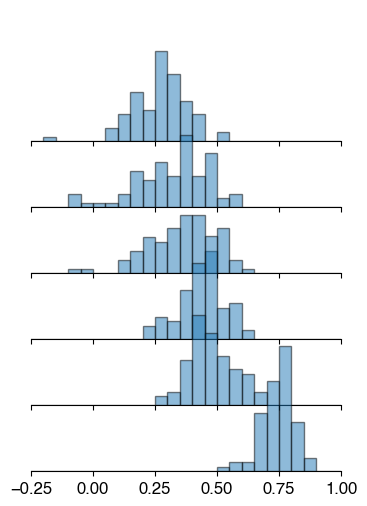

In [5]:
fig, ax= plt.subplots(6,1, figsize=(4,6), sharey=True, sharex=True)

a = ['In Vitro vs. Meninges', 'In Vitro vs. Bone', 'In Vitro vs. Spleen', 'Bone vs. Meninges','Spleen vs. Meninges', 'Spleen vs. Bone',]

bins = np.linspace(-1,1,41)
for idx, val in enumerate(a):

    subset = comps[comps['Comparison']==val]
    ax[idx].hist(subset['Correlation'], bins=bins, linewidth=1, edgecolor='black', alpha=.5)
    ax[idx].spines[['top', 'right', 'left']].set_visible(False)
    ax[idx].tick_params(axis='x', which='major', labelsize=12)
    ax[idx].set_yticks([])
    ax[idx].patch.set_facecolor('None')

ax[0].set_xlim(-.25,1)

fig.subplots_adjust(hspace=-.5)

#fig.savefig('figures/corr_hist.pdf')
#ax.set
#fig.tight_layout()

# 4b

In [6]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')

master_targ = master[master['classification']=='targeting guide']

hh = []
for i in master_targ['HGVSp_h']:
    if type(i)==str:
        i2 = i.replace('delins', '')
        hh.append(i2)
    else:
        hh.append('Non-coding')

master_targ['HGVSp_h']=hh
#master_targ['HGVSp_h'] = [i.replace('delins', '') for i in master_targ['HGVSp_h'] if type(i)==str]

#and add TSG/Oncogene info

cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')


t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in master_targ.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

master_targ['Role in Cancer']=gene_type

In [7]:
master_targ


samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']


for idx, val in enumerate(samples):

    nums = [0,1,2,3]
    nums.remove(idx)

    considering = master_targ[val]
    avgs = np.average(master_targ[[samples[i] for i in nums]], axis=1)

    delta = considering-avgs
    master_targ[f"d_{val.split('_')[1]}"] = delta




In [8]:
gRNAs_UMAP = []

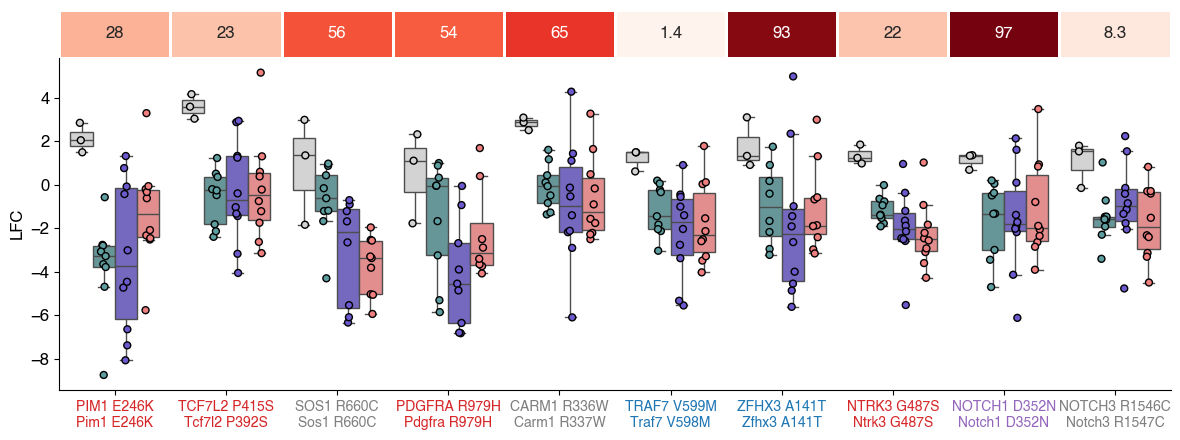

In [9]:
# in vitro specific
t = master_targ.sort_values(by='d_In Vitro D15', ascending=False)
t1 = t[(t['LFC_Spleen']<0) & (t['LFC_Meninges']<0) & (t['LFC_Bone']<0) & (t['LFC_In Vitro D15']>1) & (t['target_base_edit_perc']>=1)][:10]

gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/invitro_specific.pdf')

# 4c

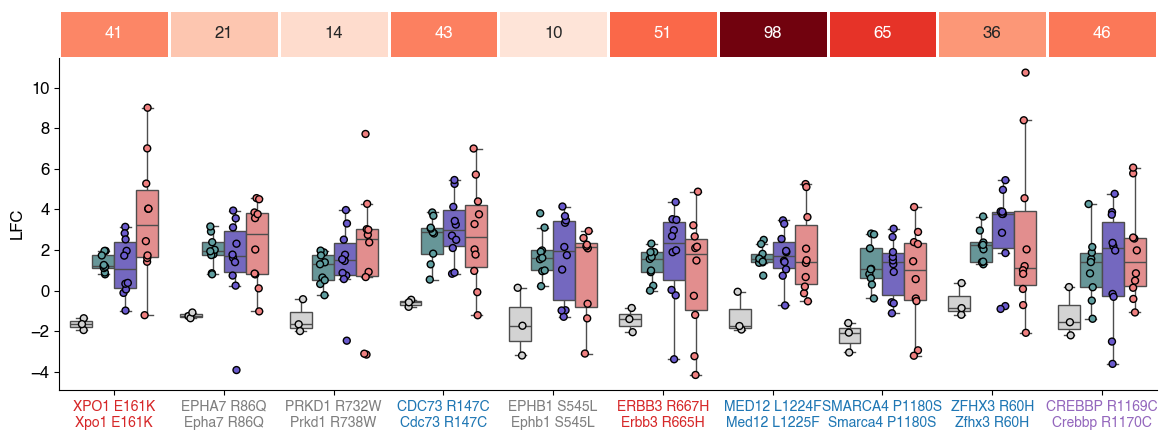

In [10]:
#in vivo specific
t = master_targ.sort_values(by='d_In Vitro D15', ascending=True)
t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)

#fig.savefig('figures/invivo_specific.pdf')

# 4e

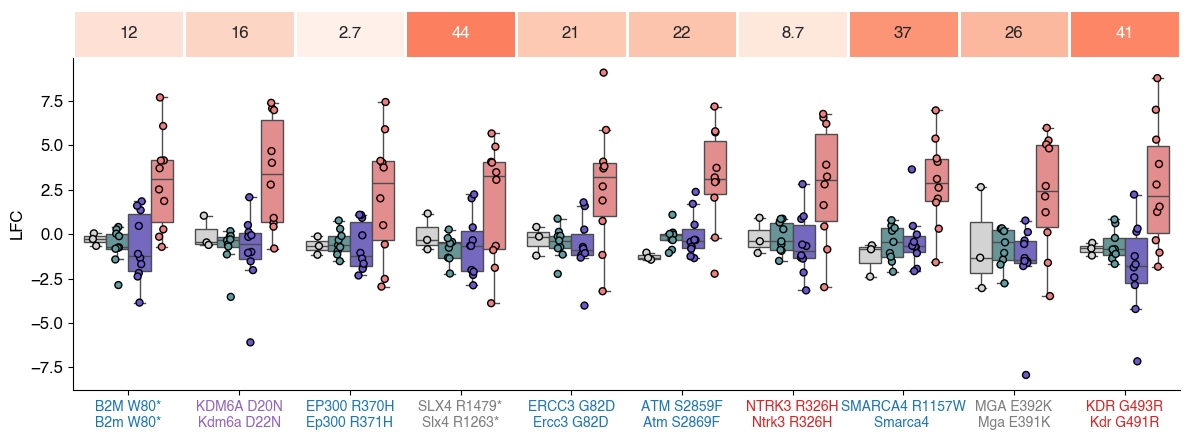

In [11]:
#meninges specific
t = master_targ.sort_values(by='d_Meninges', ascending=False)
t1 = t[(t['LFC_Spleen']<0) & (t['LFC_Meninges']>2) & (t['LFC_Bone']<0) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]

#t1 = t[(t['LFC_Spleen']<0.05) & (t['LFC_Meninges']>2) & (t['LFC_Bone']<0.05) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=10)][:10]

gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    if 'p.' in b:
        b = b[2:]
    if d == 'Not calculated (legacy)':
        d = ''

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/meninges_specific.pdf')

# 4d

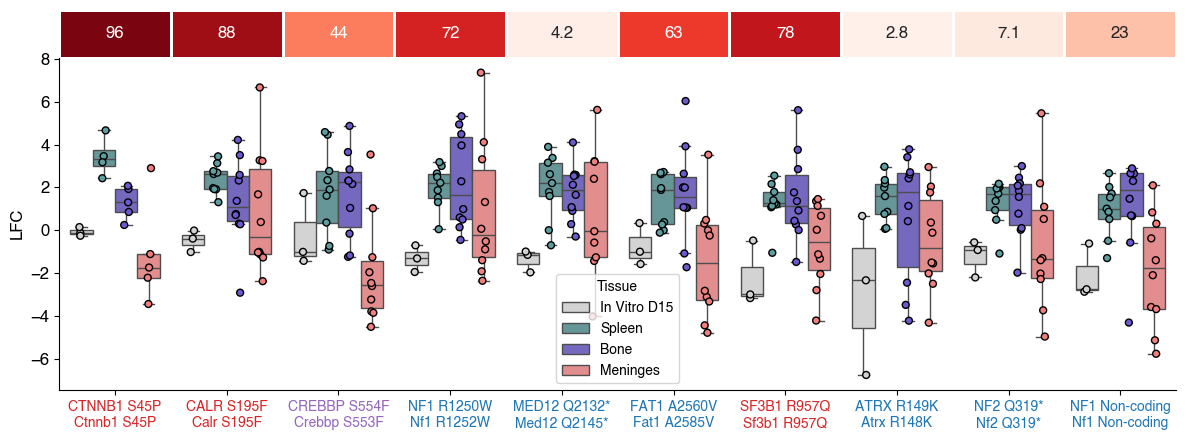

In [12]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Spleen', ascending=False)
t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']<-2)  & (t['LFC_In Vitro D15']<0.5) & (t['LFC_In Vitro D15']>-0.5) & (t['target_base_edit_perc']>=1) & (t['FDR_Spleen']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

#samples2 = ['In Vitro D15', 'Spleen',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/bone_spleen_specific.pdf')

# 4g

In [15]:
cc1 = pd.read_csv('master_table_min50_control_mean_invitro.csv')
cc1 = cc1[cc1['classification']=='targeting guide']


u,c = np.unique(cc1['gene_name_m'], return_counts=True)
top_genes = pd.DataFrame(dict(zip(['u', 'c'], [u,c]))).sort_values(by='c', ascending=False)[:20]

167
167
167
167
144
144
144
144
153
153
153
153
136
136
136
136
91
91
91
91


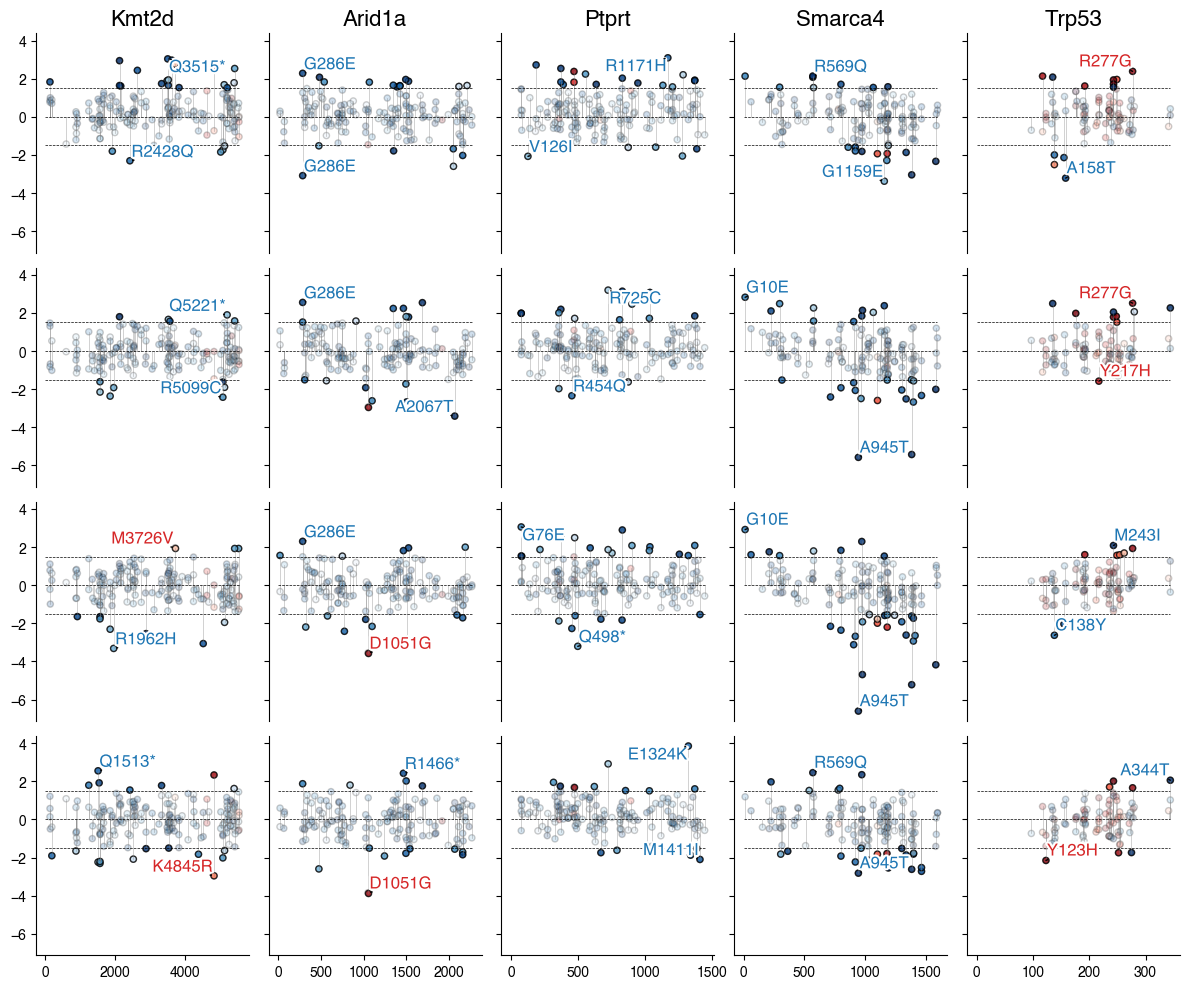

In [16]:

#for idx, gene in enumerate(top_genes[:5]):
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

#gene = 'Smarca4'

genes = ['Kmt2d', 'Arid1a', 'Ptprt', 'Smarca4', 'Trp53']

fig, ax = plt.subplots(4,5,figsize=(12,10), sharey=True) #sharey='col',)


for idx, gene in enumerate(genes):

    ptprt = cc1[(cc1['gene_name_m']==gene) & (cc1['legacy']==False) & (cc1['classification_h'].isin(['Missense', 'Nonsense'])) & (cc1['target_base_edit_perc']>=20)]

    ptprt['codon'] = [int(i[1:-1]) for i in ptprt['HGVSp_m']]


    samples = ['Z_In Vitro D15', 'Z_Spleen', 'Z_Bone', 'Z_Meninges']
    samp_dict = dict(zip(samples, ['In Vitro', 'Spleen', 'Bone', 'Meninges']))
    for kk, val2 in enumerate(samples):

        for i, val in ptprt.iterrows():
            x = val['codon']
            y = val[val2]

            ax[kk][idx].plot([x,x],[0,y], color='tab:gray', linewidth=0.5, alpha=.5)


        ptprt1 = ptprt[ptprt['Editor']=='ABE']
        ptprt2 = ptprt[ptprt['Editor']=='CBE']

        print(len(ptprt))
        #marker_sizes1 = 5*(-np.log10(np.asarray(sorted(ptprt1[f'FDR_{val2[4:]}']))+1e-10))**2 + 20
        #marker_sizes2 = 5*(-np.log10(np.asarray(sorted(ptprt2[f'FDR_{val2[4:]}']))+1e-10))**2 + 20


        ptprt1_1 = ptprt1[(ptprt1[val2]<=1.5) | (ptprt1[val2]>=-1.5)]
        ptprt1_2 = ptprt1[(ptprt1[val2]>=1.5) | (ptprt1[val2]<=-1.5)]
        ptprt2_1 = ptprt2[(ptprt2[val2]<=1.5) | (ptprt2[val2]>=-1.5)]
        ptprt2_2 = ptprt2[(ptprt2[val2]>=1.5) | (ptprt2[val2]<=-1.5)]

        #ptprt1_1 = ptprt1[(ptprt1[val2]<=1.5)] 
        #ptprt1_2 = ptprt1[(ptprt1[val2]>=1.5)] 
        #ptprt2_1 = ptprt2[(ptprt2[val2]<=1.5)] 
        #ptprt2_2 = ptprt2[(ptprt2[val2]>=1.5)]

        ax[kk][idx].scatter(ptprt1_1['codon'], ptprt1_1[val2], c=ptprt1_1['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.2)
        ax[kk][idx].scatter(ptprt1_2['codon'], ptprt1_2[val2], c=ptprt1_2['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)



        ax[kk][idx].scatter(ptprt2_1['codon'], ptprt2_1[val2], c=ptprt2_1['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.2)
        ax[kk][idx].scatter(ptprt2_2['codon'], ptprt2_2[val2], c=ptprt2_2['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)

        #and annotate top 2 and bototm 2 variants
           #and annotate top and bottom 5 variant
        tops = pd.concat((ptprt1_2, ptprt2_2)).sort_values(by=val2, ascending=False)[:1]
        bottoms = pd.concat((ptprt1_2, ptprt2_2)).sort_values(by=val2, ascending=True)[:1]
        tb = pd.concat((tops, bottoms))

        t = []
        x = []
        y = []
        c = []

        c_dict2 = {'ABE':'tab:red', 'CBE':'tab:blue'}
        for i, val3 in tb.iterrows():
            y.append(val3[val2])
            x.append(val3['codon'])
            c.append(c_dict2[val3['Editor']])
            a = val3['HGVSp_m']
    
            t.append(a)


        texts = [ax[kk][idx].text(x[i], y[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                    foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

        adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, ax=ax[kk][idx], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))



        #ax[kk].legend(*sc.legend_elements("sizes", num=6))
        #ax[kk].set_title(samp_dict[val2], fontsize=14)

        if kk==3:
            ax[kk][idx].spines[['top', 'right']].set_visible(False)
        else:
            ax[kk][idx].spines[['top', 'right', 'bottom']].set_visible(False)
            ax[kk][idx].set_xticks([])


        ax[kk][idx].tick_params(axis='both', which='major', labelsize=10,)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [0,0], linestyle='dashed', color='black',linewidth=.5)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [1.5,1.5], linestyle='dashed', color='black',linewidth=.5)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [-1.5,-1.5], linestyle='dashed', color='black',linewidth=.5)

        ax[kk][idx].set_yticks([-6,-4,-2,0,2,4])

        ax[0][idx].set_title(f'{gene}', fontsize=16)
        #ax[0][idx].set_ylim(-5,5)
        ax[kk][idx].patch.set_facecolor('None')

fig.tight_layout()
#fig.savefig('figures/lolliplops_15_transparent.png', dpi=300)